In [1]:
import json
import pickle
import numpy as np
import os.path as op
import itertools as it
from utilities import files
from mne import read_epochs
import matplotlib.pylab as plt
from matplotlib import ticker
from tqdm.notebook import trange, tqdm
from scipy.ndimage import gaussian_filter, gaussian_filter1d

In [2]:
dataset = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/sub_metrics.pkl"
beta_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/beta_result.json"

In [3]:
visual_epoch_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-145/sub-145-002-visual-epo.fif"
motor_epoch_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-145/sub-145-002-motor-epo.fif"

In [4]:
visual_epoch = read_epochs(visual_epoch_file, verbose=False)
motor_epoch = read_epochs(motor_epoch_file, verbose=False)
visual_epoch_times = visual_epoch.times
motor_epoch_times = motor_epoch.times

In [ ]:
sub_metrics = pickle.load(open(dataset, "rb"))

In [ ]:
with open(beta_file) as file:
    beta_results = json.load(file)

In [ ]:
buffer = 0.125
bin_width=0.05
baseline_range = [-0.5, -0.25]


visual_time_bins = np.arange(visual_epoch_times[0] + buffer, visual_epoch_times[-1] - buffer, bin_width)
motor_time_bins = np.arange(motor_epoch_times[0] + buffer, motor_epoch_times[-1] - buffer, bin_width)

visual_bin_ranges = list(zip(visual_time_bins[:-1], visual_time_bins[1:]))
motor_bin_ranges = list(zip(motor_time_bins[:-1], motor_time_bins[1:]))
vis_time_plot = visual_time_bins[:-1]
mot_time_plot = motor_time_bins[:-1]
vis_time_ix = np.where(
    (visual_epoch_times >= vis_time_plot[0]) &
    (visual_epoch_times <= vis_time_plot[-1])
)[0]
mot_time_ix = np.where(
    (motor_epoch_times >= mot_time_plot[0]) &
    (motor_epoch_times <= mot_time_plot[-1])
)[0]

In [ ]:
# beta calc
beta_vis = np.array(beta_results["vis"])
beta_mot = np.array(beta_results["mot"])

vis_good_ixs = np.where(np.var(beta_vis, axis=1) < 0.05)[0]
mot_good_ixs = np.where(np.var(beta_mot, axis=1) < 0.05)[0]

beta_vis = beta_vis[vis_good_ixs, :]
beta_mot = beta_mot[mot_good_ixs, :]

beta_vis_mean = np.mean(beta_vis, axis=0)
beta_vis_sem = np.std(beta_vis, axis=0) / np.sqrt(36)
beta_mot_mean = np.mean(beta_mot, axis=0)
beta_mot_sem = np.std(beta_mot, axis=0) / np.sqrt(36)

In [ ]:
burst_rate_overall_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/burst_rate_overall.pkl"
if op.exists(burst_rate_overall_file):
    burst_rate_overall = pickle.load(open(burst_rate_overall_file, "rb"))
else:
    # burst rate calc
    burst_rate_overall = {"vis": [], "mot": []}
    baseline_ixs = np.where(
        (vis_time_plot >= baseline_range[0]) &
        (vis_time_plot <= baseline_range[-1])
    )

    for sub in tqdm(sub_metrics.keys()):
        trials_vis = np.unique(sub_metrics[sub]["vis"]["pp_ix"])
        trials_mot = np.unique(sub_metrics[sub]["mot"]["pp_ix"])

        mv_burst_rate = []
        for ix, t_ix in enumerate(trials_vis):
            ixes = np.where(sub_metrics[sub]["vis"]["pp_ix"] == t_ix)
            mv_hist, t_bin_edges = np.histogram(
                sub_metrics[sub]["vis"]["peak_time"][ixes],
                bins=visual_time_bins
            )
            mv_hist = mv_hist / bin_width
            mv_burst_rate.append(gaussian_filter(mv_hist, 1))
        mv = np.mean(mv_burst_rate, axis=0)

        mm_burst_rate = []
        for ix, t_ix in enumerate(trials_mot):
            ixes = np.where(sub_metrics[sub]["mot"]["pp_ix"] == t_ix)
            mm_hist, t_bin_edges = np.histogram(
                sub_metrics[sub]["mot"]["peak_time"][ixes],
                bins=motor_time_bins
            )
            mm_hist = mm_hist / bin_width
            mm_burst_rate.append(gaussian_filter(mm_hist, 1))
        mm = np.mean(mm_burst_rate,axis=0)

        base_bursts = np.mean(mv[baseline_ixs])
        mv = (mv - base_bursts) / base_bursts
        mm = (mm - base_bursts) / base_bursts

        burst_rate_overall["vis"].append(mv)
        burst_rate_overall["mot"].append(mm)
    pickle.dump(burst_rate_overall, open(burst_rate_overall_file, "wb"))

In [ ]:
brate_mean_vis = np.mean(burst_rate_overall["vis"], axis=0)
brate_sem_vis = np.std(burst_rate_overall["vis"], axis=0) / np.sqrt(36)
brate_mean_mot = np.mean(burst_rate_overall["mot"], axis=0)
brate_sem_mot = np.std(burst_rate_overall["mot"], axis=0) / np.sqrt(36)

In [ ]:
cw_m = "#4634eb"
cw_v = "#eb346b"

baseline_ix = np.where((visual_epoch_times[vis_time_ix] >= -0.5) & (visual_epoch_times[vis_time_ix] <= -0.25))[0]
baseline = np.mean(beta_vis_mean[vis_time_ix][baseline_ix])
BETA_MEAN_VIS = beta_vis_mean[vis_time_ix] - baseline
BETA_MEAN_MOT = beta_mot_mean[mot_time_ix] - baseline

f, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"width_ratios":[3, 2.5]}, dpi=300, constrained_layout=True)
ax[0].plot(visual_epoch_times[vis_time_ix], BETA_MEAN_VIS, lw=2, color=cw_v, linestyle="--")
ax[0].fill_between(
    visual_epoch_times[vis_time_ix],
    BETA_MEAN_VIS - beta_vis_sem[vis_time_ix],
    BETA_MEAN_VIS + beta_vis_sem[vis_time_ix],
    lw=0,
    alpha=0.2, 
    color=cw_v
)
ax[0].plot(vis_time_plot, brate_mean_vis, lw=2, color=cw_v)
ax[0].fill_between(
    vis_time_plot,
    brate_mean_vis - brate_sem_vis,
    brate_mean_vis + brate_sem_vis,
    lw=0,
    alpha=0.2, 
    color=cw_v
)
ax[0].axvline(0, lw=0.5, c="black", linestyle="--")

ax[1].plot(motor_epoch_times[mot_time_ix], BETA_MEAN_MOT, lw=2, color=cw_m, linestyle="--")
ax[1].fill_between(
    motor_epoch_times[mot_time_ix],
    BETA_MEAN_MOT - beta_mot_sem[mot_time_ix],
    BETA_MEAN_MOT + beta_mot_sem[mot_time_ix],
    lw=0,
    alpha=0.2, 
    color=cw_m
)
ax[1].plot(mot_time_plot, brate_mean_mot, lw=2, color=cw_m)
ax[1].fill_between(
    mot_time_plot,
    brate_mean_mot - brate_sem_mot,
    brate_mean_mot + brate_sem_mot,
    lw=0,
    alpha=0.2, 
    color=cw_m
)
ax[1].axvline(0, lw=0.5, c="black", linestyle="--")

ax[0].set_xticks([-0.5, 0.0, 0.5, 1.0, 1.5])
ax[1].set_xticks([-0.5, 0.0, 0.5, 1.0])
ax[1].set_yticks([])

for key, spine in ax[0].spines.items():
    if key in ["top", "right"]:
        spine.set_visible(False)

for key, spine in ax[1].spines.items():
    if key in ["top", "left", "right"]:
        spine.set_visible(False)

ymin = np.min([ax[0].get_ylim()[0], ax[1].get_ylim()[0]])
ymax = np.max([ax[0].get_ylim()[1], ax[1].get_ylim()[1]])
    
ax[0].set_ylim(ymin, ymax)
ax[0].set_xlim(vis_time_plot[0], vis_time_plot[-1])
ax[1].set_ylim(ymin, ymax)
ax[1].set_xlim(mot_time_plot[0], mot_time_plot[-1])
        
plt.savefig("/scratch/BURST_PAPER/FIGURE_2_beta_vs_burst_rate.svg")

In [ ]:
gkeys = ['peak_time', 'peak_freq', 'peak_amp_base', 'fwhm_freq', 'fwhm_time']
all_metrics = {k: {i: [] for i in gkeys} for k in ["mot", "vis"]}

for sub in tqdm(sub_metrics.keys()):
    for k in gkeys:
        all_metrics["vis"][k].append(sub_metrics[sub]["vis"][k])
        all_metrics["mot"][k].append(sub_metrics[sub]["mot"][k])
for k in gkeys:
    all_metrics["vis"][k] = np.hstack(all_metrics["vis"][k]).flatten()
    all_metrics["mot"][k] = np.hstack(all_metrics["mot"][k]).flatten()

In [ ]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(6, 7), dpi=300)
ax.hist(all_metrics["vis"]["fwhm_time"]*1e3, bins=100, alpha=0.5, color=cw_v);
ax.hist(all_metrics["mot"]["fwhm_time"]*1e3, bins=100, alpha=0.5, color=cw_m);
ax.set_xlim(0, 800)
ax.set_ylabel("Number of bursts")
ax.set_xlabel("Duration [ms]")
plt.tight_layout()
plt.savefig("/scratch/BURST_PAPER/FIGURE_2_burst_duration_hist.svg")

In [ ]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(6, 7), dpi=300)
ax.hist(all_metrics["vis"]["peak_amp_base"]/1e-15, bins=1000, alpha=0.5, color=cw_v);
ax.hist(all_metrics["mot"]["peak_amp_base"]/1e-15, bins=350, alpha=0.5, color=cw_m);
ax.set_xlim(0, 110)
ax.set_ylabel("Number of bursts")
ax.set_xlabel("Amplitude [fT]")
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
plt.tight_layout()
plt.savefig("/scratch/BURST_PAPER/FIGURE_2_amplitude_hist.svg")

In [ ]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(6, 7), dpi=300)
ax.hist(all_metrics["vis"]["peak_freq"], bins=57, alpha=0.5, color=cw_v);
ax.hist(all_metrics["mot"]["peak_freq"], bins=57, alpha=0.5, color=cw_m);
ax.set_xlim(13, 30)
ax.set_ylabel("Number of bursts")
ax.set_xlabel("Peak Frequency [Hz]")
ax.ticklabel_format(axis="y", style="sci", scilimits=(10, 3))
plt.tight_layout()
plt.savefig("/scratch/BURST_PAPER/FIGURE_2_peak_frequency_hist.svg")

In [ ]:
cw_m = "#4634eb"
cw_v = "#eb346b"

f, ax = plt.subplots(1, 1, figsize=(6, 7), dpi=300)
ax.hist(all_metrics["vis"]["fwhm_freq"], bins=30, alpha=0.5, color=cw_v);
ax.hist(all_metrics["mot"]["fwhm_freq"], bins=30, alpha=0.5, color=cw_m);
ax.set_xlim(0, 9)
ax.set_ylabel("Number of bursts")
ax.set_xlabel("Frequency Span [Hz]")
plt.tight_layout()
plt.savefig("/scratch/BURST_PAPER/FIGURE_2_freq_span_hist.svg")

In [5]:
waveform_array_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/all_waveforms.npy"
waveform_array = np.load(waveform_array_file)
waveform_time = np.linspace(-.13, .13, num=156)

In [6]:
mean_waveform = np.mean(waveform_array, axis=0)

In [7]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

SNR = signaltonoise(waveform_array, axis=0, ddof=1)

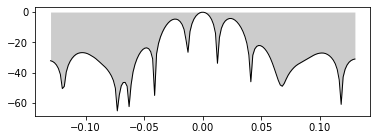

In [81]:
f, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(waveform_time, 10*np.log10(SNR**2), lw=1, color="black")
ax.fill_between(waveform_time, np.zeros(waveform_time.shape), 10*np.log10(SNR**2), lw=0, color="black", alpha=0.2)
ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

In [5]:
from scipy.stats import sign

(14328947, 156)

In [8]:
np.mean(10*np.log10(SNR**2))

-27.16382367624683

In [9]:
np.std(10*np.log10(SNR**2))

14.603382620873536

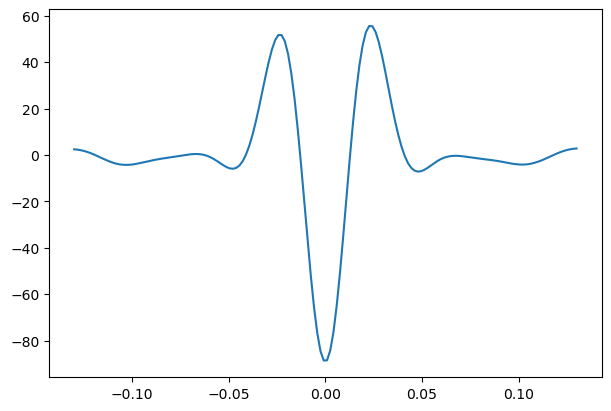

In [41]:
f, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100, constrained_layout=True)
ax.plot(waveform_time, mean_waveform/1e-15)


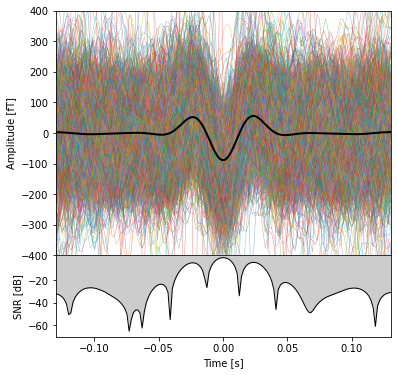

In [78]:
fig = plt.figure(figsize=(6, 6), constrained_layout=False)
grid = fig.add_gridspec(2,1, wspace=0, hspace=0, height_ratios=(4.5, 1.5))

xx0 = grid[0, 0].subgridspec(1,1)
ax0 = xx0.subplots()
ax0.set_xticks([])
ax0.plot(waveform_time, waveform_array[::5000,:].T/1e-15, lw=0.5, alpha=0.5)
ax0.plot(waveform_time, mean_waveform/1e-15, lw=2, c="black")
ax0.set_ylim(-400, 400)
ax0.set_xlim(-0.13, 0.13)
ax0.set_ylabel("Amplitude [fT]")

xx1 = grid[1, 0].subgridspec(1,1)
ax1 = xx1.subplots()
ax1.fill_between(waveform_time, np.zeros(waveform_time.shape)+2, 10*np.log10(SNR**2), lw=0, color="black", alpha=0.2)
ax1.plot(waveform_time, 10*np.log10(SNR**2), lw=1, color="black")
ax1.set_ylim(-70, 2)
ax1.set_xlim(-0.13, 0.13)
ax1.set_ylabel("SNR [dB]")
ax1.set_xlabel("Time [s]")
ax1.set_yticks([-20, -40, -60])
plt.savefig("/scratch/BURST_PAPER/FIGURE_2_waveform_snr.svg")